# Baum-Welch算法

本教程改编自相关课程[链接](http://isle.illinois.edu/speech_web_lg/coursematerials/ece417/19fall/slides/ece417fa2018lecture13.html)

本教程介绍了 HMM 训练过程所使用的 Baum-Welch 算法。首先使用一个自定义 HMM 模型生成训练数据，然后，初始化 HMM 模型参数并使用 Baum-Welch 算法对模型参数进行迭代求解

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 定义用于生成数据的 HMM 模型

$$\pi_i=\Pr\left\{q_1=i\right\}$$
$$a_{ij}=\Pr\left\{q_{t+1}=j|q_t=i\right\}$$
$$\mu_{di}=E\left[x_{dt}|q_t=i\right]$$
$$\Sigma_{i}=E\left[(\vec{x}_{t}-\vec\mu_{i})(\vec{x}_{t}-\vec\mu_{i})^T|q_t=i\right]$$

使用每个参数的真实值生成数据，然后尝试使用每个参数的估计值来识别数据

* 为了方便, 设 $\pi_i=\delta[i-1]$
* $a_{ij}=0$ unless $j\in\left\{i,i+1\right\}$.  此处设 $a_{ii}=0.8$
* 观测向量为 $12$ 维，每个状态的向量均值不同
* 假设观测向量的协方差矩阵为对角阵，可以用一个方差向量表示

In [2]:
states = [0,1,2,3]
N = len(states)-1 # Define N as the number of emitting states
pi_true = [1,0,0,0]
A_true = [[0.8,0.2,0,0],[0,0.8,0.2,0],[0,0,0.8,0.2]]
mu_true = [[2,2,2,2,0,0,0,0,0,0,0,0],[0,0,0,0,2,2,2,2,0,0,0,0],[0,0,0,0,0,0,0,0,2,2,2,2]]
sigsq_true = [[1,1,1,1,1,1,1,1,1,1,1,1],[2,2,2,2,2,2,2,2,2,2,2,2],[1,1,1,1,1,1,1,1,1,1,1,1]]


# 根据 HMM 模型生成数据
假设 $q=3$ 为终止状态。根据 HMM 的双重随机过程的特点，首先生成状态序列, 再生成观测向量

Text(0.5, 1.0, 'True State Sequence')

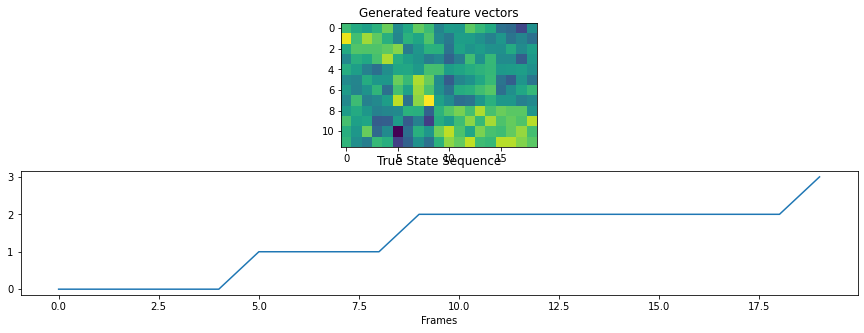

In [3]:
Q = list(np.random.choice(states,1,p=pi_true))
q = Q[-1]
X = []
while q < 3:
    xt = stats.multivariate_normal.rvs(mean=mu_true[q],cov=np.diag(sigsq_true[q]))
    X.append(xt)
    Q.extend(np.random.choice(states,1,p=A_true[q]))
    q = Q[-1]

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.imshow(np.transpose(X))
plt.title('Generated feature vectors')
plt.subplot(212)
plt.plot(Q)
plt.xlabel('Frames')
plt.title('True State Sequence')

# HMM 模型训练过程中的初始化

将训练样本在时间维度上均匀分为三部分，假设分别对应于三个状态。HMM 模型参数三元组分别为
 
* pi: 假设已知初始分布 $\pi$（记为 pi）
* A: 通过估计每个状态的持续时间 $d=T/3$, 假设转移概率 $a_{i,i+1}=1/d$
* B: 假定每一状态对应的观测均为高斯分布


Text(0.5, 0, 'Feature dimension')

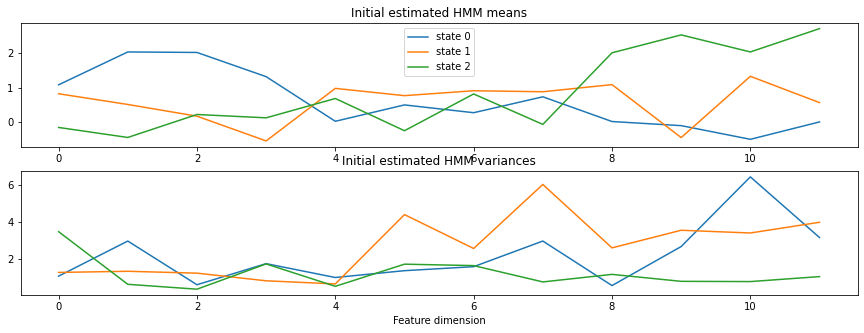

In [4]:
pi=[1,0,0,0]
T=len(X)
d=int(T/3)
a=1/d
A=[[1-a,a,0,0],[0,1-a,a,0],[0,0,1-a,a]]
mu=[np.average(X[0:d],axis=0),np.average(X[d:2*d],axis=0),np.average(X[2*d:T],axis=0)]
Sigma=[np.cov(X[0:d],rowvar=False)+0.2*np.identity(12),np.cov(X[d:2*d],rowvar=False)+0.2*np.identity(12),np.cov(X[2*d:T],rowvar=False)+0.2*np.identity(12)]
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(np.transpose(mu))
plt.legend(['state 0','state 1','state 2'])
plt.title('Initial estimated HMM means')
plt.subplot(212)
plt.plot(np.transpose([ np.diag(S) for S in Sigma ]))
plt.title('Initial estimated HMM variances')
plt.xlabel('Feature dimension')

模型初始化后采用 Baum-Welch 算法进行训练，Baum-Welch算法也是一种 EM (Expectation-Maximization) 算法，包括E step 和 M step 两个阶段。



### E-step part 1

首先计算 $B$ 矩阵，其中 时刻 t，状态 i 的观测对应的概率为 $p(\vec{x}_t|q_t=i)$
$$b_i(\vec{x}_t)=p(\vec{x}_t|q_t=i)=\frac{1}{(2\pi)^{D/2}|\Sigma_i|^{1/2}}e^{-\frac{1}{2}(\vec{x}_t-\vec\mu_{i})^T\Sigma_i^{-1}(\vec{x}_t-\vec\mu_i)}$$
假设协方差矩阵为对角阵。在本例中，观测向量维度为12
$$b_i(\vec{x}_t)=\prod_{d=1}^{12} \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{-\frac{1}{2}\left(\frac{x_{dt}-\mu_{di}}{\sigma_i}\right)^2}$$


Text(0, 0.5, 'State number')

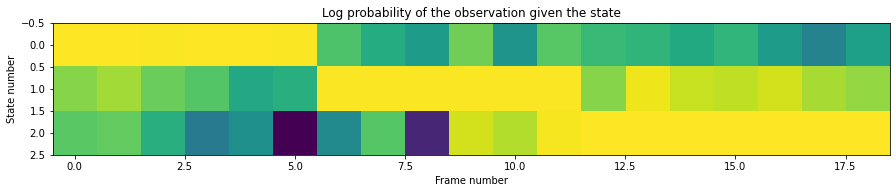

In [5]:
B=np.zeros((N,T))
for t in range(0,T):
    for i in range(0,N):
        B[i,t]=stats.multivariate_normal(mu[i],Sigma[i]).pdf(X[t])
plt.figure(figsize=(15,5))
plt.imshow(np.log(B))
plt.title('Log probability of the observation given the state')
plt.xlabel('Frame number')
plt.ylabel('State number')


### E-Step part 2
分别计算 $\alpha,\beta,\gamma,\xi$
$$\alpha_0(i)=\Pr\left\{q_0=i,\vec{x}_0\right\}=\pi_i b_i(\vec{x}_0)$$
$$\alpha_t(i)=\Pr\left\{q_t=i,\vec{x}_0,\ldots,\vec{x}_t\right\}=b_i(\vec{x}_t)\sum_{j=0}^{N-1}\alpha_{t-1}(j)a_{ji}$$
$$\beta_{T-1}(i)=1$$
$$\beta_{t}(i)=\Pr\left\{\vec{x}_{t+1},\ldots,\vec{x}_{T-1}|q_t=i\right\}\sum_{j=0}^{N-1}a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)$$
$$\gamma_t(i)=\Pr\left\{q_t=i|\vec{x}_0,\ldots,\vec{x}_{T-1}\right\}=\frac{\alpha_t(i)\beta_t(i)}{\sum_{j=0}^{N-1}\alpha_t(j)\beta_t(j)}$$
$$\xi_t(i,j)=\Pr\left\{q_t=i,q_{t+1}=j|\vec{x}_0,\ldots,\vec{x}_{T-1}\right\}=\frac{\alpha_t(i)a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)}{\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}\alpha_t(i)a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)}$$

注意仅当 $j\in\left\{i,i+1\right\}$ 时 $a_{ij}\not=0$, 仅当 $j\in\left\{i,i+1\right\}$ 时 $\xi_t(i,j)\not=0$

<ipython-input-6-22a5903007fe>:32: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(0,T),np.transpose(np.log(alpha)),range(0,T),np.transpose(np.log(beta)))


Text(0.5, 0, 'Frame index, t')

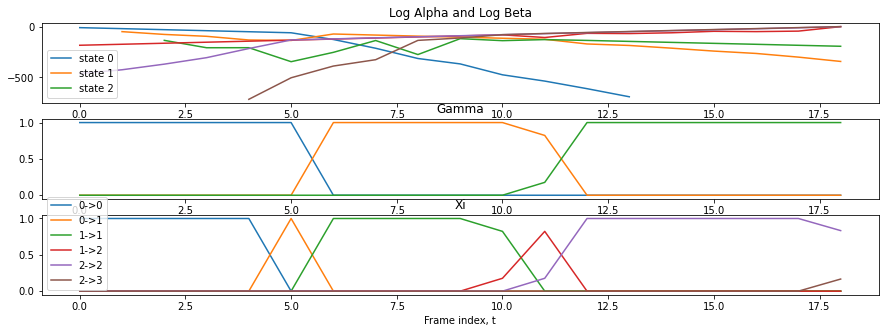

In [6]:
alpha = np.zeros((N,T))
beta = np.zeros((N,T))
gamma = np.zeros((N,T))
xi = np.zeros((2*N,T))
Amat = np.array(A)  # Convert to an np matrix so we can compute inner products
for i in range(0,N):
    alpha[i,0]=pi[i]*B[i,0]
for t in range(1,T):
    for i in range(0,N):
        alpha[i,t]=B[i,t]*np.inner(alpha[:,t-1],Amat[:,i])
for i in range(0,N):
    beta[i,T-1]=1
for t in range(T-2,-1,-1):
    for i in range(0,N):
        beta[i,t]=np.inner(Amat[i,0:N],beta[:,t+1]*B[:,t+1])
for t in range(0,T):
    gamma[:,t]=alpha[:,t]*beta[:,t]
    gamma[:,t]=gamma[:,t]/np.sum(gamma[:,t])
for t in range(0,T):
    for i in range(0,N):
        for j in range(i,i+2):
            xi[i+j,t]=alpha[i,t]*Amat[i,j]
            if (t<T-1):
                if j==N:
                    xi[i+j,t]=0
                else:
                    xi[i+j,t] = xi[i+j,t]*B[j,t+1]*beta[j,t+1]
    xi[:,t]=xi[:,t]/np.sum(xi[:,t])
    
plt.figure(figsize=(15,5))
plt.subplot(311)
plt.plot(range(0,T),np.transpose(np.log(alpha)),range(0,T),np.transpose(np.log(beta)))
plt.title('Log Alpha and Log Beta')
plt.legend(['state 0','state 1','state 2'])
plt.subplot(312)
plt.plot(np.transpose(gamma))
plt.title('Gamma')
plt.subplot(313)
plt.plot(np.transpose(xi))
plt.legend(['0->0','0->1','1->1','1->2','2->2','2->3'])
plt.title('Xi')
plt.xlabel('Frame index, t')


### M-Step（使用多个训练样本时的算法）

$$a_{ij}=\frac{\sum_\ell\sum_t \xi_{t\ell}(i,j)}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx \Pr\left\{q_{t+1}=j|q_t=i\right\}$$
$$\vec\mu_i=\frac{\sum_\ell\sum_t\gamma_{t\ell}(i)\vec{x}_t}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx E\left[\vec{x}_{t}|q_t=i\right]$$
$$\sigma_{di}^2=\frac{\sum_\ell\sum_t\gamma_{t\ell}(i)(x_{dt}-\mu_{di})^2}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx E\left[(x_{dt}-\mu_{di})^2|q_t=i\right]$$

Text(0.5, 0, 'Feature Dimension')

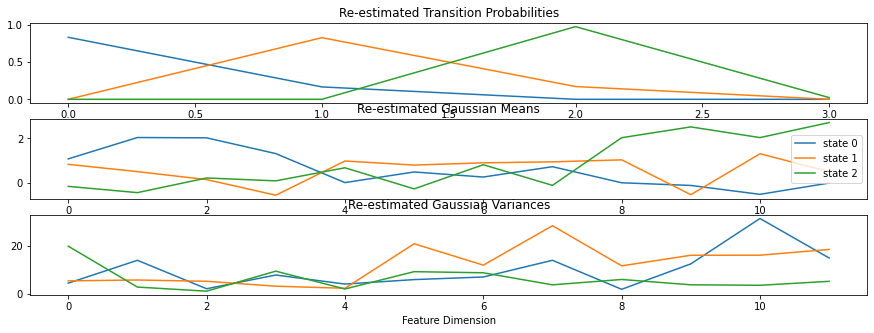

In [7]:
for i in range(0,N):
    for j in range(i,i+2):
        A[i][j]=np.sum(xi[i+j,:])/np.sum(gamma[i,:])
for i in range(0,N):
    mu[i] = np.inner(np.transpose(X),gamma[i,:])/np.sum(gamma[i,:])
for i in range(0,N):
    Sigma[i]=0.2*np.identity(12)
    for t in range(0,len(X)):
        Sigma[i] += gamma[i,t]*np.outer(X[t]-mu[i],X[t]-mu[i])
plt.figure(figsize=(15,5))
plt.subplot(311)
plt.plot(np.transpose(A))
plt.title('Re-estimated Transition Probabilities')
plt.subplot(312)
plt.plot(np.transpose(mu))
plt.title('Re-estimated Gaussian Means')
plt.legend(['state 0','state 1','state 2'])
plt.subplot(313)
plt.plot(np.transpose([np.diag(S) for S in Sigma]))
plt.title('Re-estimated Gaussian Variances')
plt.xlabel('Feature Dimension')

### EM 算法的迭代
完整的训练过程需要对 E step 和 M step 不断进行迭代，直到算法收敛